In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA # to do predictions
from pmdarima.arima import auto_arima # a wrapper
import seaborn as sns
import numpy as np

-------------

In [99]:
dfw = pd.read_csv("datos-clima\processed\Clima_info.csv")

dfw = dfw[dfw['ANIO'] >= 2020]
dfw = dfw[dfw['VARIABLE'] == 'Temperatura_Promedio']

dfw = dfw.groupby("FECHA_PROXY").mean(numeric_only=True).reset_index()
dfw = dfw.sort_values("FECHA_PROXY")
dfw

,FECHA_PROXY,ANIO,VALOR,MES_NUM
0,2020-01-15,2020.0,15.950000,1.0
1,2020-02-15,2020.0,17.540625,2.0
2,2020-03-15,2020.0,18.693750,3.0
3,2020-04-15,2020.0,21.375000,4.0
4,2020-05-15,2020.0,22.890625,5.0
5,2020-06-15,2020.0,23.456250,6.0
6,2020-07-15,2020.0,23.093750,7.0
7,2020-08-15,2020.0,23.356250,8.0
8,2020-09-15,2020.0,22.915625,9.0
9,2020-10-15,2020.0,20.793750,10.0


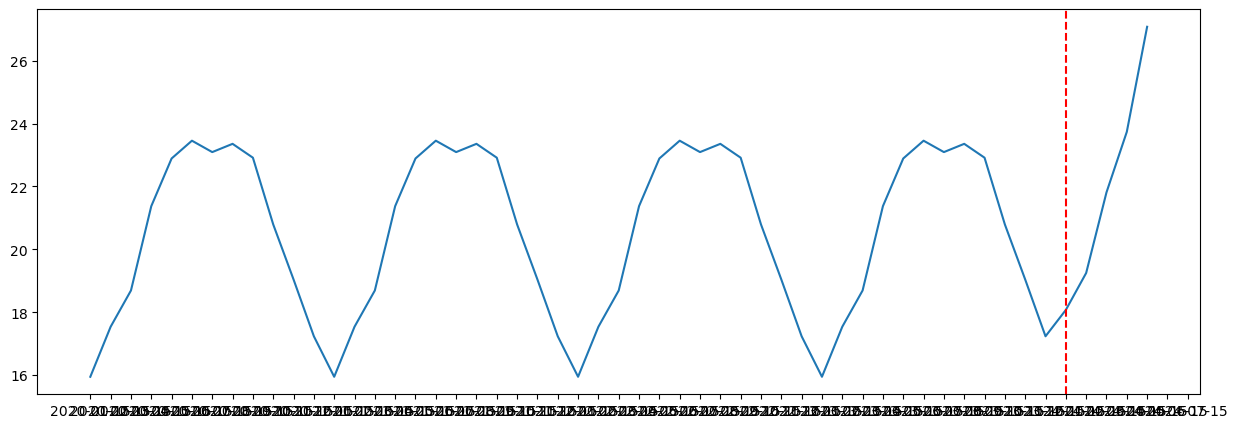

In [100]:
plt.figure(figsize=(15, 5))
plt.plot(dfw['FECHA_PROXY'], dfw['VALOR'])
plt.axvline(x='2024-01-15', color='red', linestyle='--', label='Año: 2024')
plt.show()

In [133]:
variable = dfw['VALOR']
variable = variable.dropna()

----------------

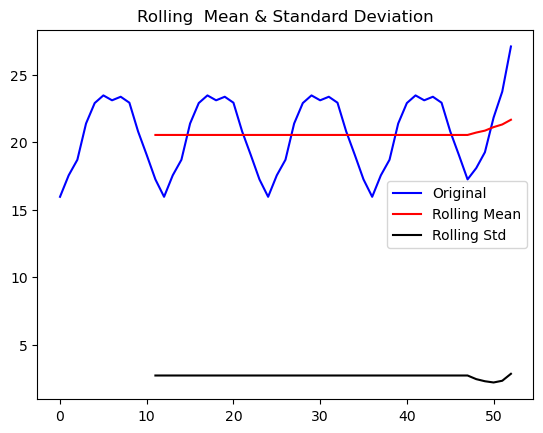

Results of Dickey-Fuller Test:
Test Statistic                  8.594244
p-value                         1.000000
#Lags Used                     11.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64
Results of kpss Test:
Test Statistic           0.060551
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\User\AppData\Local\Temp\ipykernel_50492\966820571.py:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


In [134]:
def test_stationarity(timeseries):

    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()

    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

    #kpss test:
    print('Results of kpss Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

test_stationarity(variable)

In [135]:
m = int(np.log(len(variable)))
print(acorr_ljungbox(variable, lags=[m]))

     lb_stat     lb_pvalue
3  40.009153  1.060760e-08


### Explicación Dickey-Fuller, KPSS y Ljung-Box Test
- Dickey-Fuller: p-value 0.06 > 0.05
- KPSS: p-value 0.01 < 0.05
- Ljung-Box: p-value 0.00 < 0.05

-----------------------------------------------------------------

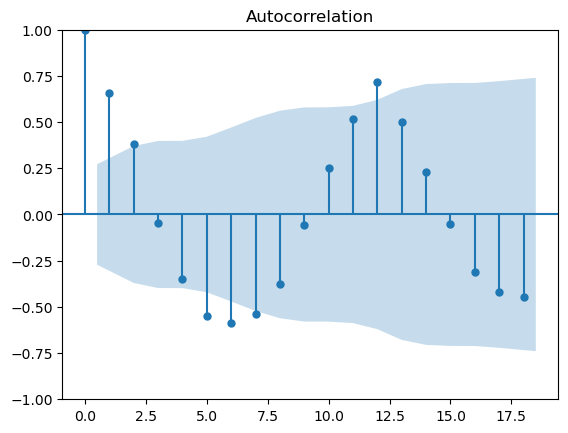

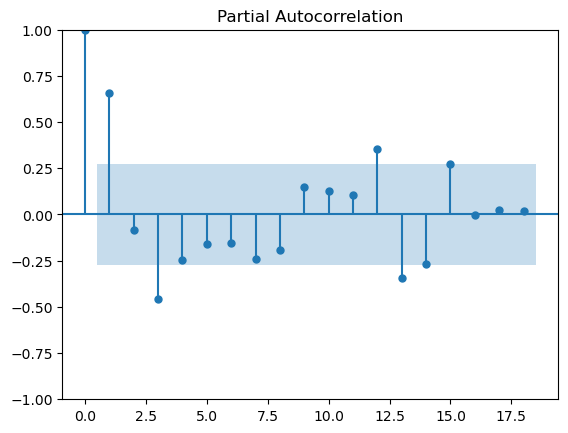

In [136]:
df_diff = diff(variable)
plot_acf(df_diff)
plt.show()
plot_pacf(df_diff)
plt.show()

----

In [137]:
model = auto_arima(variable, trace=True, error_action='raise')
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=142.658, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=259.847, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=203.326, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=217.174, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=474.331, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=141.093, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=184.257, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=152.323, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=142.496, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=141.644, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=143.685, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=178.052, Time=0.08 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.694 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   53
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -65.546
Date:              mar., 03 jun. 2025   AIC                            141.093
Time:                        13:52:42   BIC                            150.944
Sample:                             0   HQIC                           144.881
                                 - 53                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.6870      0.600      9.474      0.000       4.510       6.863
ar.L1          1.6961      0.042     40.445      0.000       1.614       1.778
ar.L2         -0.9710      0.041    -23.974      0.000      -1.050      -0.892
ma.L1         -0.6297      0.150     -4.193      0.000      -0.924      -0.335
sigma2         0.6154      0.194      3.166      0.002       0.234       0.996
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 7.58
Prob(Q):                              0.65   Prob(JB):                         0.02
Heteroskedasticity (H):               1.90   Skew:                             0.90
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [138]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(variable, order=(2,1,2))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALOR   No. Observations:                   53
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -62.111
Date:              mar., 03 jun. 2025   AIC                            134.221
Time:                        13:52:42   BIC                            143.977
Sample:                             0   HQIC                           137.961
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7266      0.016    104.643      0.000       1.694       1.759
ar.L2         -0.9990      0.007   -133.570      0.000      -1.014      -0.984
ma.L1         -1.7699      6.779     -0.261      0.7

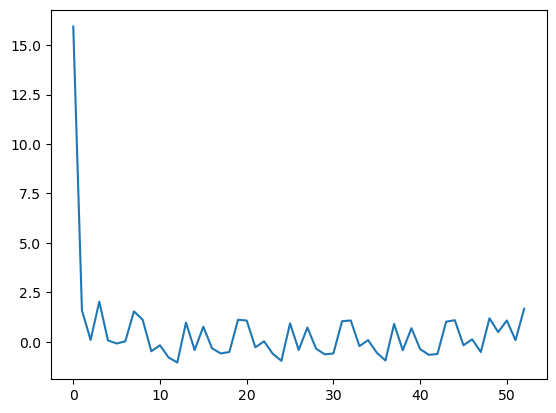

In [139]:
residuals = pd.DataFrame(results.resid, columns=['res'])
plt.plot(residuals)

In [140]:
residuals['res2'] = residuals['res'] ** 2
SSE = round(residuals['res2'].sum(),2)
print('SSE:',"{:,}".format(SSE))

SSE: 289.33


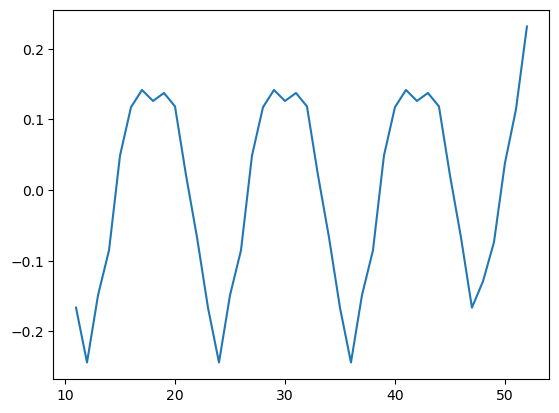

In [141]:
tslog = np.log(variable)
rollavg = tslog.rolling(12).mean()
tslogdiff = tslog - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

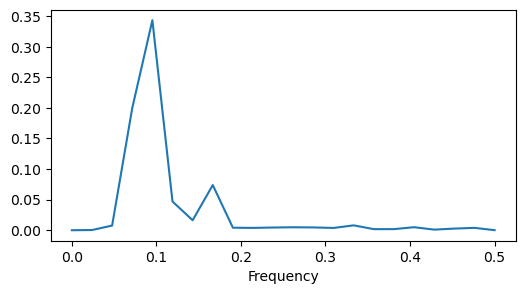

In [142]:
from scipy import signal
f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.show()

Podemos observar que hay una frecuencia clara, cercano al 0.1 y al 0.2, siendo la primera mucho más pronunciada, lo que podemos verificar al ver el grafico del dataster original

In [143]:
top_4_periods = {}

# get indices for 4 highest Pxx values
top4_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]


freqs = f[top4_freq_indices]

# use same indices to get powers as well
power = Pxx[top4_freq_indices]

# we are interested in period and it is calculated as 1/frequency
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_4_periods['period1'] = periods[0]
top_4_periods['freq1'] = freqs[0]
top_4_periods['power1'] = power[0]

top_4_periods['period2'] = periods[1]
top_4_periods['freq2'] = freqs[1]
top_4_periods['power2'] = power[1]

top_4_periods['period3'] = periods[2]
top_4_periods['freq3'] = freqs[2]
top_4_periods['power3'] = power[2]

top_4_periods['period4'] = periods[3]
top_4_periods['freq4'] = freqs[3]
top_4_periods['power4'] = power[3]

top_4_periods

{'period1': 10.5,
 'freq1': 0.09523809523809523,
 'power1': 0.3433960296418281,
 'period2': 14.0,
 'freq2': 0.07142857142857142,
 'power2': 0.19968392186448689,
 'period3': 6.0,
 'freq3': 0.16666666666666666,
 'power3': 0.07386602429762289,
 'period4': 8.4,
 'freq4': 0.11904761904761904,
 'power4': 0.04696591646137997}

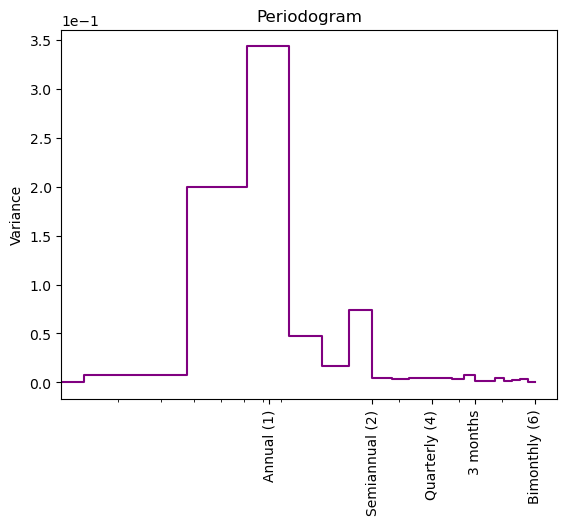

In [144]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    freqencies, spectrum = periodogram(ts)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1/12, 1/6, 1/4, 1/3, 1/2])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "3 months",
            "Bimonthly (6)",


        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(tslogdiff)
plt.show()

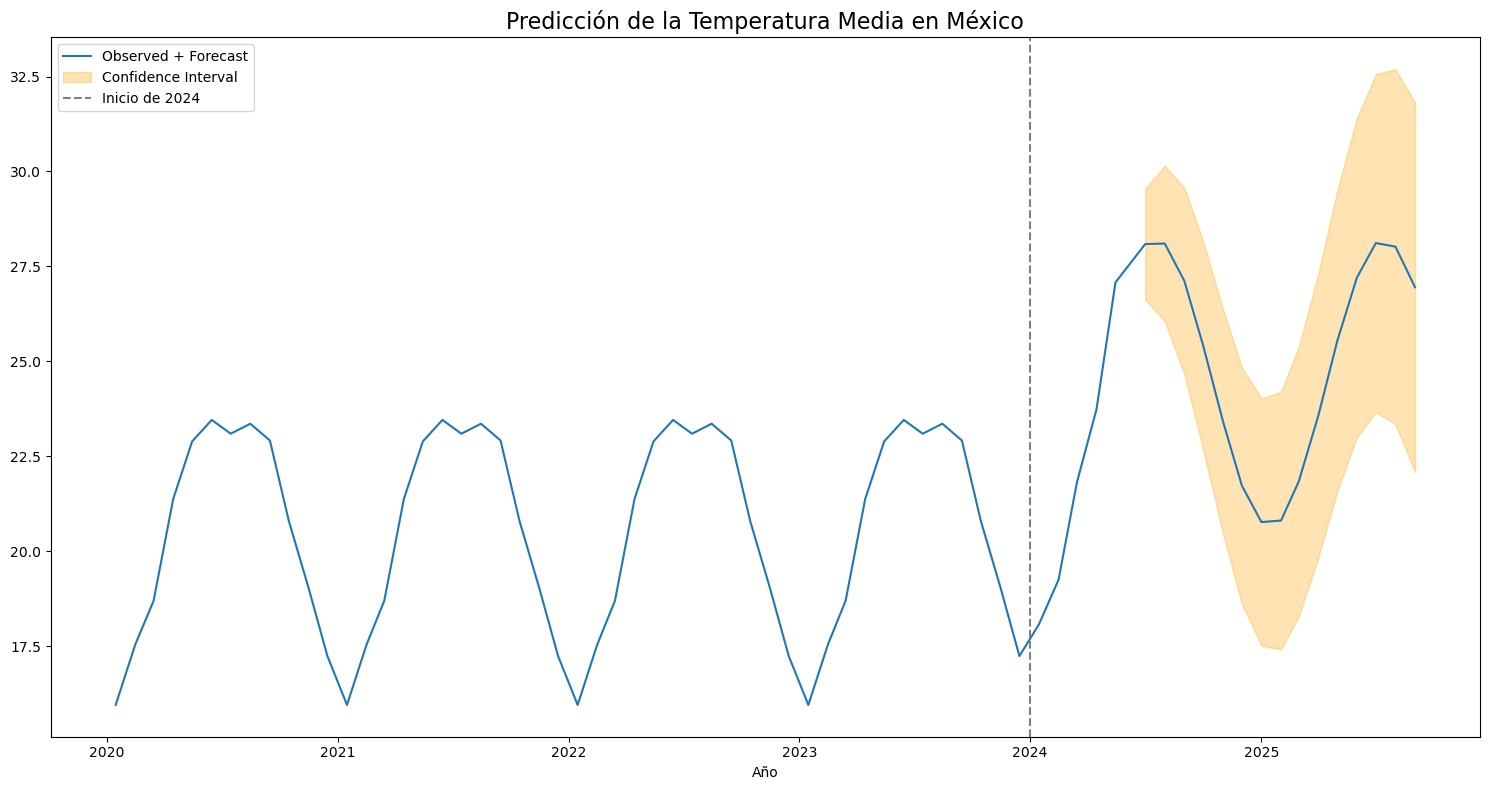

In [182]:
forecast_obj = results.get_forecast(steps=15)
forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()  

fechas_obs = pd.to_datetime(dfw['FECHA_PROXY'][:53])
future_dates = pd.date_range(start=fechas_obs.iloc[-1] + pd.DateOffset(months=1),
                             periods=len(forecast), freq='MS')

fechas_completas = list(fechas_obs) + list(future_dates)
variable_completa = pd.concat([variable, forecast], ignore_index=True)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(fechas_completas, variable_completa, label='Observed + Forecast')
ax.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                color='orange', alpha=0.3, label='Confidence Interval')

ax.axvline(pd.Timestamp('2024-01-01'), color='gray', linestyle='--', label='Inicio de 2024')

años_unicos = sorted(set([f.year for f in fechas_completas]))
ticks = [pd.Timestamp(f"{a}-01-01") for a in años_unicos]
ax.set_xticks(ticks)
ax.set_xticklabels([str(a) for a in años_unicos])

ax.legend(loc='upper left')
plt.title('Predicción de la Temperatura Media en México', fontsize=16)
plt.xlabel('Año')
plt.tight_layout()
plt.show()
